In [1]:
!pip install transformers pandas

In [6]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm


In [5]:
#sample data
tweets = [
    "I had a great experience flying with United Airlines!",
    "The flight was delayed and customer service was terrible.",
    "Nothing special, just a normal trip.",
    "Worst flight ever. Never flying again.",
    "Amazing service and friendly crew!"
]

sentiment_classifier = pipeline("sentiment-analysis")
for tweet in tweets:
    result = sentiment_classifier(tweet)[0]
    print(f"Tweet: {tweet}")
    print(f"Prediction: {result['label']} | Confidence: {round(result['score'], 2)}\n")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Tweet: I had a great experience flying with United Airlines!
Prediction: POSITIVE | Confidence: 1.0

Tweet: The flight was delayed and customer service was terrible.
Prediction: NEGATIVE | Confidence: 1.0

Tweet: Nothing special, just a normal trip.
Prediction: NEGATIVE | Confidence: 1.0

Tweet: Worst flight ever. Never flying again.
Prediction: NEGATIVE | Confidence: 1.0

Tweet: Amazing service and friendly crew!
Prediction: POSITIVE | Confidence: 1.0



In [7]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df = df[['text','airline_sentiment']].dropna()
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [21]:
sentiment = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [22]:
df_sample = df.sample(100, random_state=42).copy()
df_sample['bert_sentiment3'] = df_sample['text'].apply(lambda t: sentiment(t)[0]['label'].lower())

In [23]:
# Normalize the predicted labels to lowercase
df_sample['bert_sentiment3'] = df_sample['bert_sentiment3'].str.lower()


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
print(classification_report(df_sample['airline_sentiment'], df_sample['bert_sentiment3']))

              precision    recall  f1-score   support

    negative       0.93      0.87      0.90        62
     neutral       0.68      0.68      0.68        19
    positive       0.78      0.95      0.86        19

    accuracy                           0.85       100
   macro avg       0.80      0.83      0.81       100
weighted avg       0.86      0.85      0.85       100



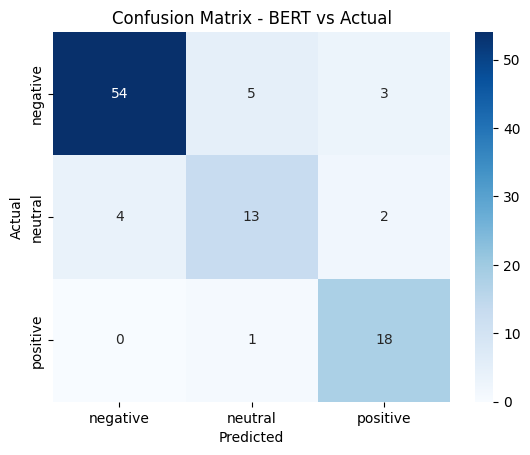

In [25]:
# Confusion matrix
cm = confusion_matrix(df_sample['airline_sentiment'], df_sample['bert_sentiment3'])
sns.heatmap(cm, annot=True, xticklabels=['negative','neutral','positive'], yticklabels=['negative','neutral','positive'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - BERT vs Actual')
plt.show()